<a href="https://colab.research.google.com/github/Bekamgenene/Elevvo-Internship-Program/blob/main/Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Install and import required libraries**

In [1]:
!pip install kaggle opendatasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


**Step 2: Download and extract dataset**

In [2]:
import opendatasets as od

dataset_url = "https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bekamg
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


100%|██████████| 612M/612M [00:03<00:00, 174MB/s] 


**Step 3: Load and explore the dataset**

In [9]:
def load_data(data_dir):
    images = []
    labels = []

    # Read training data
    train_csv = pd.read_csv(os.path.join(data_dir, "Train.csv"))

    for idx, row in train_csv.iterrows():
        img_path = os.path.join(data_dir, row['Path'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (32, 32))  # Resize images to 32x32
        images.append(image)
        labels.append(row['ClassId'])

    return np.array(images), np.array(labels)

In [10]:
# Load training data
data_dir = "./gtsrb-german-traffic-sign"
images, labels = load_data(data_dir)

print("Number of images:", len(images))
print("Number of labels:", len(labels))

Number of images: 39209
Number of labels: 39209


In [13]:
# Load the data
data_dir = "./gtsrb-german-traffic-sign"
images, labels = load_data(data_dir)

print(f"Dataset loaded: {len(images)} images, {len(np.unique(labels))} classes")
print(f"Image shape: {images[0].shape}")

Dataset loaded: 39209 images, 43 classes
Image shape: (32, 32, 3)


**Step 4: Data preprocessing**

In [14]:
def preprocess_images(images, target_size=(32, 32)):
    processed_images = []

    for img in images:
        # Resize
        img_resized = cv2.resize(img, target_size)
        # Normalize pixel values to [0, 1]
        img_normalized = img_resized / 255.0
        processed_images.append(img_normalized)

    return np.array(processed_images)

In [15]:
# Preprocess images
X_processed = preprocess_images(images)
y = labels

print(f"Processed images shape: {X_processed.shape}")

Processed images shape: (39209, 32, 32, 3)


**Step 5: Train-test split**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (25093, 32, 32, 3)
Validation set: (6274, 32, 32, 3)
Test set: (7842, 32, 32, 3)


**Step 6: Data visualization**

In [18]:
def visualize_samples(X, y, class_names=None, num_samples=12):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(3, 4, i + 1)
        idx = random.randint(0, len(X) - 1)
        plt.imshow(X[idx])
        if class_names is not None:
            plt.title(f"Class: {class_names[y[idx]]}")
        else:
            plt.title(f"Class: {y[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


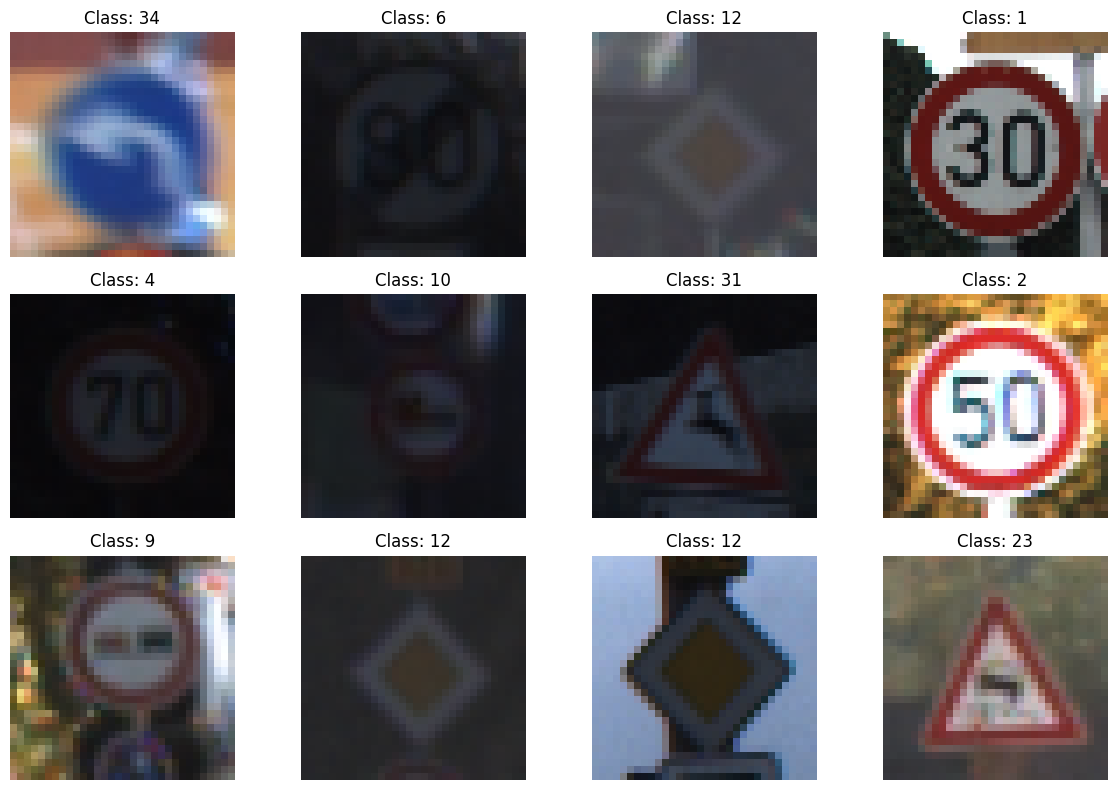

In [19]:
# Visualize some samples
visualize_samples(X_train, y_train)

**Step 7: Build Custom CNN Model**

In [20]:
def create_custom_cnn(input_shape=(32, 32, 3), num_classes=43):
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fully connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [21]:
# Create and compile custom CNN
custom_cnn = create_custom_cnn()
custom_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

custom_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,481,419 (5.65 MB)

 Trainable params: 1,479,947 (5.65 MB)

 Non-trainable params: 1,472 (5.75 KB)

**Step 8: Data Augmentation**

In [22]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

**Step 9: Callbacks**

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7
)

**Step 10: Train Custom CNN Model**

In [24]:
print("Training Custom CNN Model...")
history_custom = custom_cnn.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training Custom CNN Model...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


785/785 ━━━━━━━━━━━━━━━━━━━━ 245s 305ms/step - accuracy: 0.1673 - loss: 3.4362 - val_accuracy: 0.6478 - val_loss: 1.0850 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 244s 311ms/step - accuracy: 0.6216 - loss: 1.1689 - val_accuracy: 0.8915 - val_loss: 0.3418 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 257s 305ms/step - accuracy: 0.8272 - loss: 0.5439 - val_accuracy: 0.9692 - val_loss: 0.1022 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 244s 310ms/step - accuracy: 0.8985 - loss: 0.3170 - val_accuracy: 0.9761 - val_loss: 0.0729 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 243s 309ms/step - accuracy: 0.9302 - loss: 0.2214 - val_accuracy: 0.9857 - val_loss: 0.0445 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 243s 310ms/step - accuracy: 0.9459 - loss: 0.1707 - val_accuracy: 0.9869 - val_loss: 0.0501 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 244s 311ms/step - accuracy: 0.9508 

**Step 11: Build and Train Pre-trained Model (MobileNetV2)**

In [25]:
def create_mobilenet_model(input_shape=(32, 32, 3), num_classes=43):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),

        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [26]:
# Create MobileNet model
mobilenet_model = create_mobilenet_model()
mobilenet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

print("Training MobileNet Model...")
history_mobilenet = mobilenet_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

/tmp/ipython-input-1769999517.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,428,011 (9.26 MB)

 Trainable params: 169,771 (663.17 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

Training MobileNet Model...
Epoch 1/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 75s 88ms/step - accuracy: 0.1417 - loss: 3.4857 - val_accuracy: 0.2863 - val_loss: 2.4757 - learning_rate: 0.0010
Epoch 2/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 67s 69ms/step - accuracy: 0.2482 - loss: 2.6256 - val_accuracy: 0.3087 - val_loss: 2.3381 - learning_rate: 0.0010
Epoch 3/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.2723 - loss: 2.4852 - val_accuracy: 0.3264 - val_loss: 2.2931 - learning_rate: 0.0010
Epoch 4/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.2768 - loss: 2.4440 - val_accuracy: 0.3279 - val_loss: 2.2500 - learning_rate: 0.0010
Epoch 5/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.2869 - loss: 2.4279 - val_accuracy: 0.3400 - val_loss: 2.2241 - learning_rate: 0.0010
Epoch 6/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.2929 - loss: 2.3777 - val_accuracy: 0.3435 - val_loss: 2.1957 - learning_rate: 0.0010
Epoch 7/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms

**Step 12: Fine-tuning MobileNet**

In [27]:
def fine_tune_model(model):
    model.layers[0].trainable = True
    fine_tune_at = 100
    for layer in model.layers[0].layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [28]:
# Fine-tune MobileNet
mobilenet_model = fine_tune_model(mobilenet_model)

print("Fine-tuning MobileNet Model...")
history_fine_tune = mobilenet_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Fine-tuning MobileNet Model...
Epoch 1/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 131s 147ms/step - accuracy: 0.0698 - loss: 4.2396 - val_accuracy: 0.0934 - val_loss: 3.6578
Epoch 2/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 110s 140ms/step - accuracy: 0.1134 - loss: 3.6218 - val_accuracy: 0.0877 - val_loss: 3.4322
Epoch 3/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 110s 140ms/step - accuracy: 0.1450 - loss: 3.2789 - val_accuracy: 0.1267 - val_loss: 3.2159
Epoch 4/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 110s 140ms/step - accuracy: 0.1672 - loss: 3.0936 - val_accuracy: 0.1878 - val_loss: 2.9418
Epoch 5/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 114s 145ms/step - accuracy: 0.1870 - loss: 2.9528 - val_accuracy: 0.2286 - val_loss: 2.6934
Epoch 6/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 109s 139ms/step - accuracy: 0.2060 - loss: 2.8363 - val_accuracy: 0.2673 - val_loss: 2.5097
Epoch 7/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 110s 140ms/step - accuracy: 0.2257 - loss: 2.7122 - val_accuracy: 0.2836 - val_loss: 2.3841
Epoch 8/20
785/785 ━━━━━━━━━━━━━━━━━━━━ 113s 

**Step 13: Model Evaluation**

In [29]:
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n{'='*50}")
    print(f"Evaluating {model_name}")
    print(f"{'='*50}")

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))

    return y_pred_classes, test_accuracy


In [30]:
# Evaluate both models
y_pred_custom, acc_custom = evaluate_model(custom_cnn, X_test, y_test, "Custom CNN")
y_pred_mobilenet, acc_mobilenet = evaluate_model(mobilenet_model, X_test, y_test, "MobileNetV2")


Evaluating Custom CNN
246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step
Test Accuracy: 0.9996
Test Loss: 0.0022

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       444
           2       1.00      1.00      1.00       450
           3       1.00      1.00      1.00       282
           4       1.00      1.00      1.00       396
           5       1.00      1.00      1.00       372
           6       1.00      1.00      1.00        84
           7       1.00      1.00      1.00       288
           8       1.00      1.00      1.00       282
           9       1.00      1.00      1.00       294
          10       1.00      1.00      1.00       402
          11       1.00      1.00      1.00       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      1.00      1.00       156
     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Step 14: Confusion Matrix**

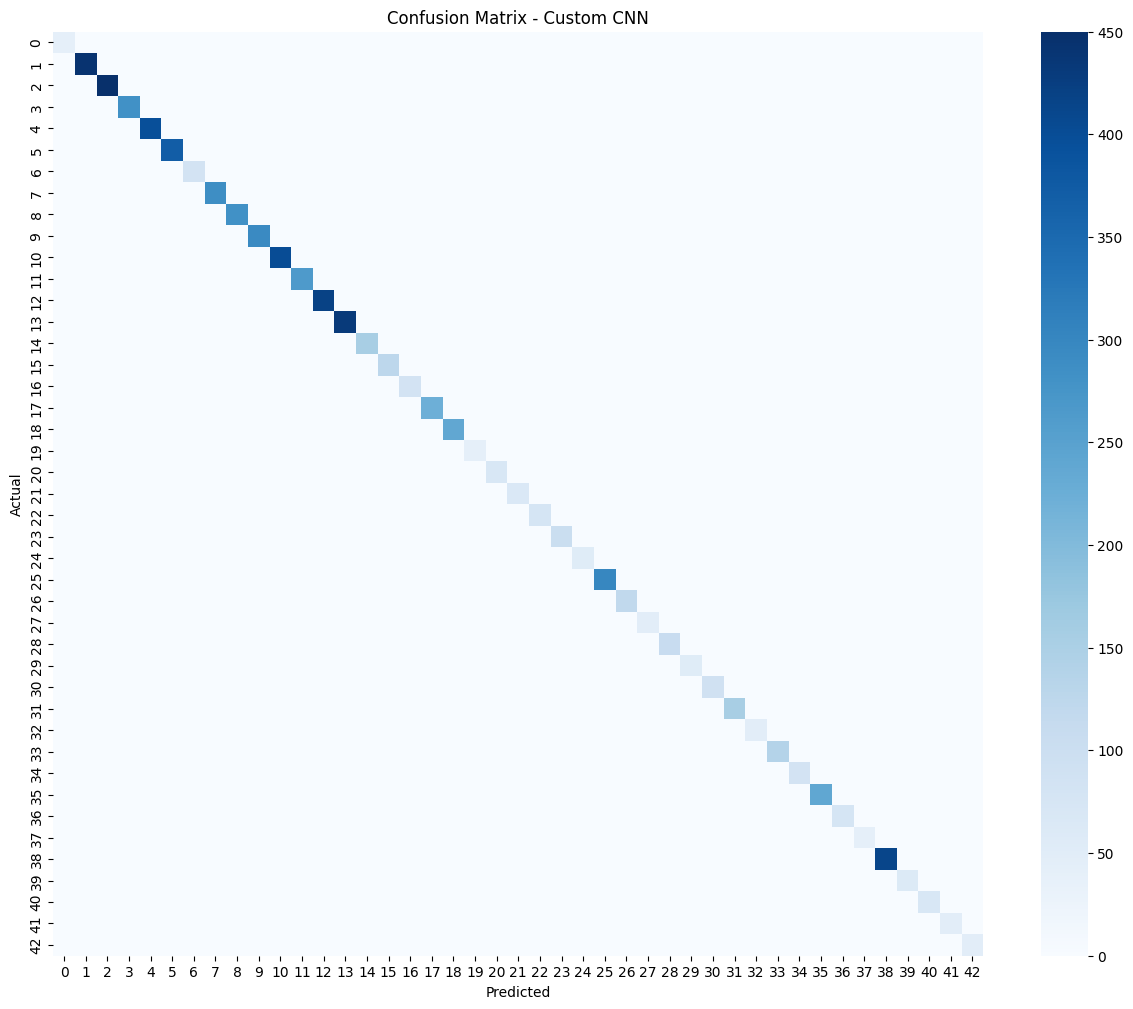

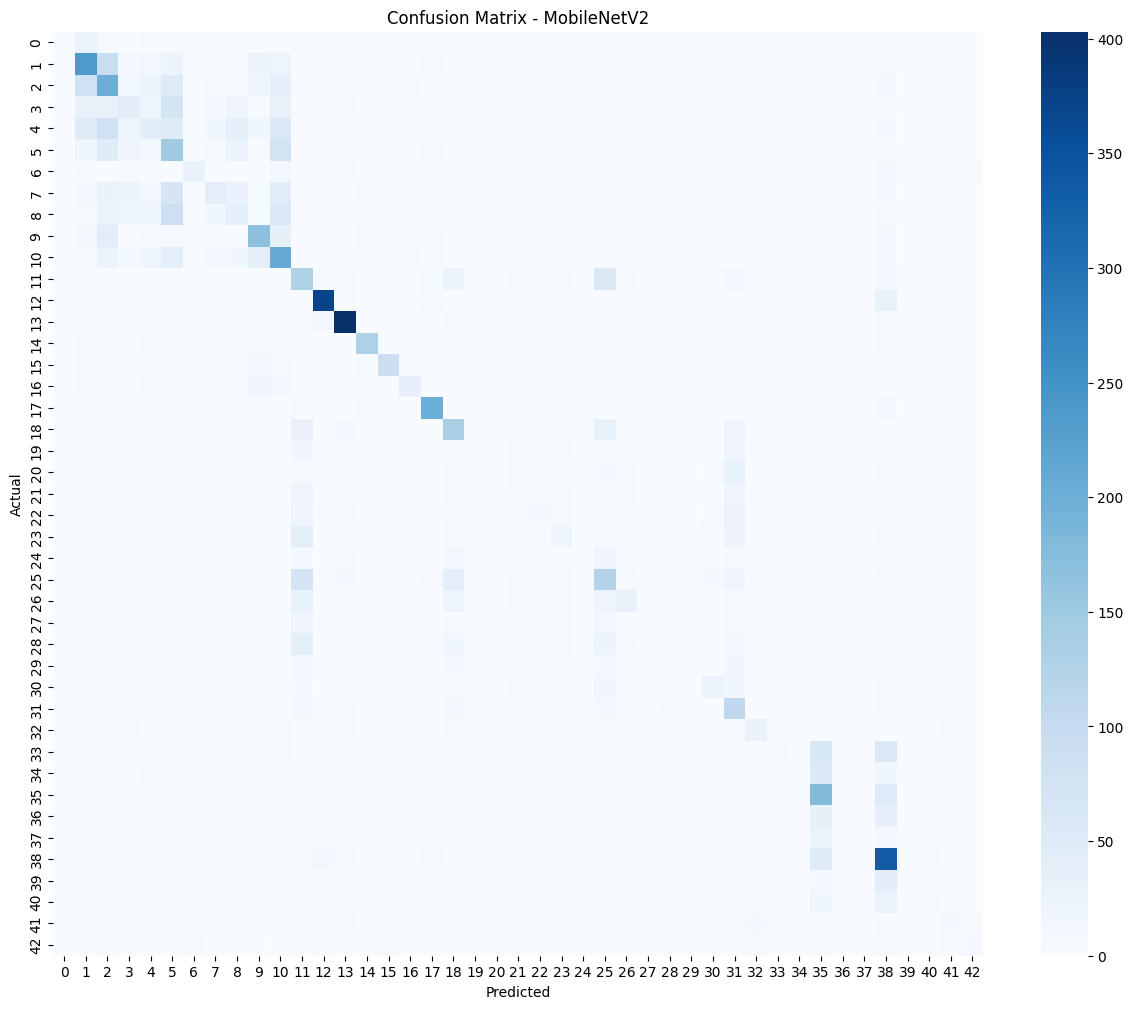

In [31]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=range(43), yticklabels=range(43))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, y_pred_custom, "Custom CNN")
plot_confusion_matrix(y_test, y_pred_mobilenet, "MobileNetV2")


**Step 15: Training History Visualization**

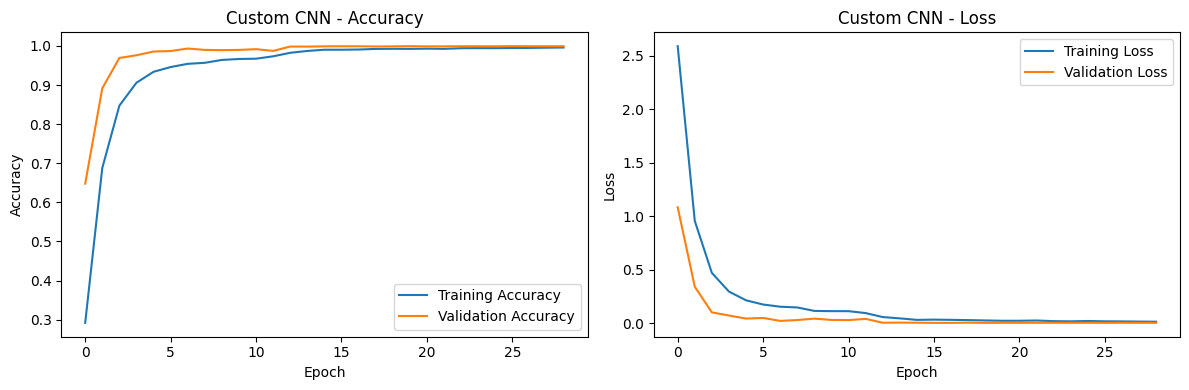

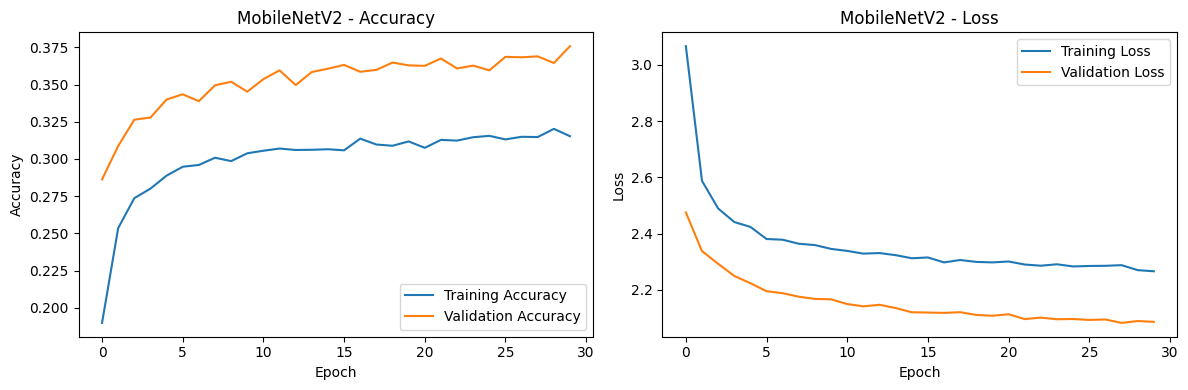

In [38]:
def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_custom, "Custom CNN")
plot_training_history(history_mobilenet, "MobileNetV2")

 **Step 16: Model Comparison**


Model Comparison:
         Model  Test Accuracy
0   Custom CNN       0.999617
1  MobileNetV2       0.453966


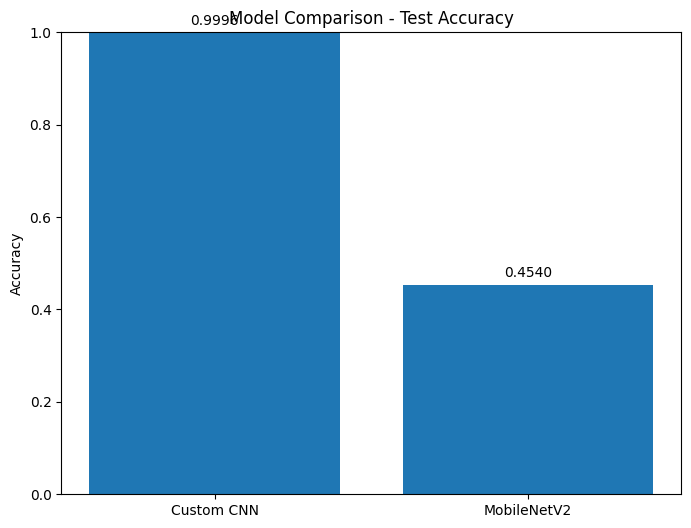

In [39]:
models_comparison = pd.DataFrame({
    'Model': ['Custom CNN', 'MobileNetV2'],
    'Test Accuracy': [acc_custom, acc_mobilenet]
})

print("\nModel Comparison:")
print(models_comparison)

plt.figure(figsize=(8, 6))
plt.bar(models_comparison['Model'], models_comparison['Test Accuracy'])
plt.title('Model Comparison - Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(models_comparison['Test Accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.show()

**Step 17: Sample Predictions**

In [45]:
def visualize_predictions(model, X_test, y_test, model_name, num_samples=8):
    plt.figure(figsize=(15, 10))

    # let get random samples
    indices = random.sample(range(len(X_test)), num_samples)

    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        img = X_test[idx]
        true_label = y_test[idx]

        prediction = model.predict(np.expand_dims(img, axis=0))
        pred_label = np.argmax(prediction)
        confidence = np.max(prediction)

        # Plot image
        plt.imshow(img)
        plt.title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}')
        plt.axis('off')

        # Color code: green if correct, red if wrong
        if true_label == pred_label:
            plt.gca().patch.set_edgecolor('green')
        else:
            plt.gca().patch.set_edgecolor('red')
        plt.gca().patch.set_linewidth(3)

    plt.suptitle(f'Predictions - {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


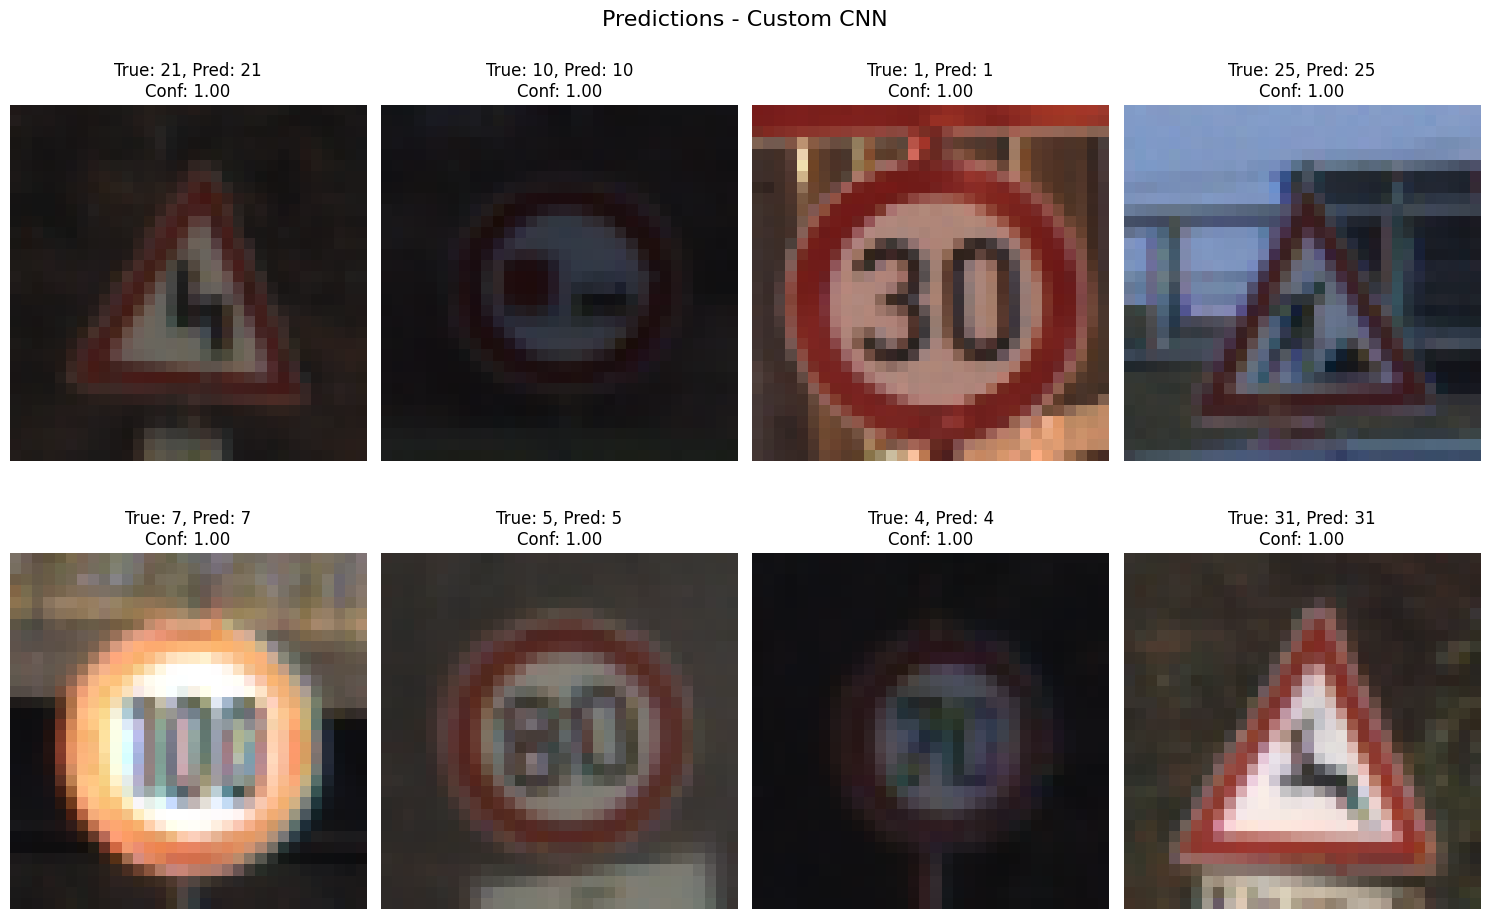

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


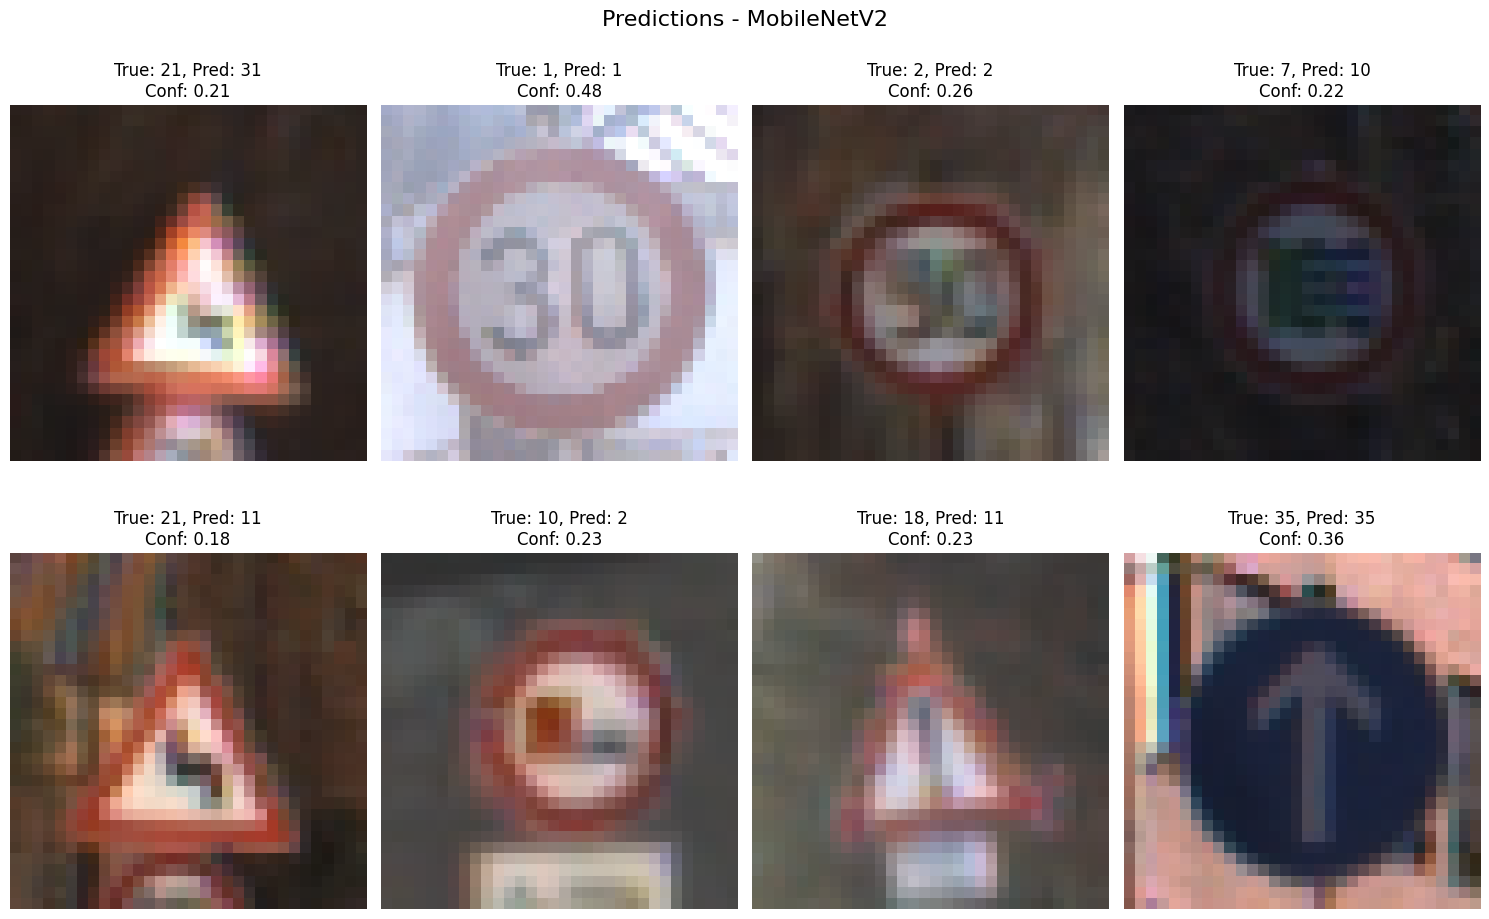

In [46]:
visualize_predictions(custom_cnn, X_test, y_test, "Custom CNN")
visualize_predictions(mobilenet_model, X_test, y_test, "MobileNetV2")

**Step 18: Save Models**

In [48]:
custom_cnn.save('traffic_sign_custom_cnn.h5')
mobilenet_model.save('traffic_sign_mobilenet.h5')
print("Models saved successfully!")

Models saved successfully!


**Step 19: Final Summary**

In [49]:
print("\n" + "="*60)
print("TRAFFIC SIGN RECOGNITION PROJECT SUMMARY")
print("="*60)
print(f"Dataset: GTSRB (German Traffic Sign Recognition Benchmark)")
print(f"Total Classes: 43")
print(f"Total Images: {len(images)}")
print(f"Training Set: {X_train.shape[0]} images")
print(f"Validation Set: {X_val.shape[0]} images")
print(f"Test Set: {X_test.shape[0]} images")
print(f"\nModel Performance:")
print(f"  Custom CNN Test Accuracy: {acc_custom:.4f}")
print(f"  MobileNetV2 Test Accuracy: {acc_mobilenet:.4f}")
print(f"\nBest Model: {'MobileNetV2' if acc_mobilenet > acc_custom else 'Custom CNN'}")
print("="*60)


TRAFFIC SIGN RECOGNITION PROJECT SUMMARY
Dataset: GTSRB (German Traffic Sign Recognition Benchmark)
Total Classes: 43
Total Images: 39209
Training Set: 25093 images
Validation Set: 6274 images
Test Set: 7842 images

Model Performance:
  Custom CNN Test Accuracy: 0.9996
  MobileNetV2 Test Accuracy: 0.4540

Best Model: Custom CNN
